In [149]:
import sys
import os
import re
import pandas as pd
from torchnlp.datasets import imdb_dataset

In [150]:
data_path = r'E:\kaggle\movies'
train_data_path = os.path.join(data_path,'labeledTrainData.tsv')
test_data_path = os.path.join(data_path,'testData.tsv')

In [151]:
train = imdb_dataset(train=True)
train[0]  # RETURNS: {'text': 'For a movie that gets..', 'sentiment': 'pos'}

{'sentiment': 'pos',
 'text': 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'}

In [152]:
import pandas as pd
df_imdb = pd.DataFrame(list(train),index=range(25000,50000))
df_imdb.head()

,sentiment,text
25000,pos,Bromwell High is a cartoon comedy. It ran at t...
25001,pos,Homelessness (or Houselessness as George Carli...
25002,pos,Brilliant over-acting by Lesley Ann Warren. Be...
25003,pos,This is easily the most underrated film inn th...
25004,pos,This is not the typical Mel Brooks film. It wa...


In [153]:
df_imdb['sentiment'] = df_imdb['sentiment'].map({'pos':1,'neg':0})
df_imdb.head()

,sentiment,text
25000,1,Bromwell High is a cartoon comedy. It ran at t...
25001,1,Homelessness (or Houselessness as George Carli...
25002,1,Brilliant over-acting by Lesley Ann Warren. Be...
25003,1,This is easily the most underrated film inn th...
25004,1,This is not the typical Mel Brooks film. It wa...


In [154]:
train_df = pd.read_csv(train_data_path,header=0,sep='\t')
train_df.rename(columns={'review':'text'},inplace=True)
train_df = train_df.drop('id',axis=1)
train_df.head()

,sentiment,text
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [155]:
x_df = pd.concat([train_df,df_imdb])
x_df.head()
x_df.tail()

,sentiment,text
49995,0,"Towards the end of the movie, I felt it was to..."
49996,0,This is the kind of movie that my enemies cont...
49997,0,I saw 'Descent' last night at the Stockholm Fi...
49998,0,Some films that you pick up for a pound turn o...
49999,0,"This is one of the dumbest films, I've ever se..."


In [156]:
x_df['text'][0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [157]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    # 单词变体还原 默认还原 'n' 名词
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    # 'v' 还原动词  'a'  形容词   'r' 副词
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text
x_df['_text'] = x_df.text.apply(clean_text)
x_df.head()

,sentiment,text,_text
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [158]:
x_df._text[0]

"stuff go moment mj ive start listen music watch odd documentary watch wiz watch moonwalker maybe want get certain insight guy think wa really cool eighty maybe make mind whether guilty innocent moonwalker part biography part feature film remember go see cinema wa originally release ha subtle message mjs feel towards press also obvious message drug bad mkaybr br visually impressive course michael jackson unless remotely like mj anyway go hate find bore may call mj egotist consent make movie mj fan would say make fan true really nice himbr br actual feature film bite finally start 20 minute exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad beyond mj overhear plan nah joe pescis character rant want people know supply drug etc dunno maybe hate mjs music<br /><br />lots cool thing like mj turn car robot whole speed demon sequence. also, director must patience saint come film kiddy bad sequence usually director hate work one kid let alone w

In [159]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_df['_text'])
list_token_train = tokenizer.texts_to_sequences(x_df['_text'])
len(list_token_train)

50000

In [160]:
x_df._text.apply(lambda x:len(x.split(" "))).mean()

129.51444

In [161]:
maxlen = 130
X_t = pad_sequences(list_token_train,maxlen=maxlen)
print(X_t.shape)
y = x_df['sentiment']
len(y)

(50000, 130)


50000

In [162]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 300
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

batch_size = 100
epochs = 3
history = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         1800000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_13 (Dense)             (None, 20)                10260     
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 2,951,017
Trainable params: 2,951,017
Non-trainable params: 0
_________________________________________________________________
None
Train on 45000 samples, validate on 5000 samples
Epoch 1/3


20400/45000 [============>.................] - ETA: 58:00 - loss: 0.6932 - acc: 0.47 - ETA: 35:08 - loss: 0.6897 - acc: 0.51 - ETA: 27:37 - loss: 0.6942 - acc: 0.49 - ETA: 23:51 - loss: 0.6958 - acc: 0.49 - ETA: 21:26 - loss: 0.6942 - acc: 0.50 - ETA: 19:53 - loss: 0.6940 - acc: 0.50 - ETA: 18:44 - loss: 0.6925 - acc: 0.52 - ETA: 17:54 - loss: 0.6914 - acc: 0.52 - ETA: 17:16 - loss: 0.6903 - acc: 0.53 - ETA: 16:43 - loss: 0.6883 - acc: 0.54 - ETA: 16:18 - loss: 0.6880 - acc: 0.54 - ETA: 15:54 - loss: 0.6863 - acc: 0.54 - ETA: 15:33 - loss: 0.6865 - acc: 0.54 - ETA: 15:17 - loss: 0.6852 - acc: 0.54 - ETA: 15:02 - loss: 0.6888 - acc: 0.54 - ETA: 14:49 - loss: 0.6907 - acc: 0.53 - ETA: 14:39 - loss: 0.6904 - acc: 0.53 - ETA: 14:29 - loss: 0.6901 - acc: 0.53 - ETA: 14:22 - loss: 0.6893 - acc: 0.53 - ETA: 14:16 - loss: 0.6889 - acc: 0.54 - ETA: 14:09 - loss: 0.6884 - acc: 0.54 - ETA: 14:04 - loss: 0.6876 - acc: 0.55 - ETA: 13:59 - loss: 0.6868 - acc: 0.55 - ETA: 13:56 - loss: 0.6866 - acc: 

40800/45000 [==========================>...] - ETA: 8:13 - loss: 0.4144 - acc: 0.805 - ETA: 8:11 - loss: 0.4134 - acc: 0.805 - ETA: 8:09 - loss: 0.4127 - acc: 0.805 - ETA: 8:07 - loss: 0.4122 - acc: 0.806 - ETA: 8:05 - loss: 0.4113 - acc: 0.806 - ETA: 8:03 - loss: 0.4107 - acc: 0.807 - ETA: 8:00 - loss: 0.4103 - acc: 0.807 - ETA: 7:58 - loss: 0.4096 - acc: 0.808 - ETA: 7:56 - loss: 0.4094 - acc: 0.808 - ETA: 7:54 - loss: 0.4088 - acc: 0.808 - ETA: 7:52 - loss: 0.4084 - acc: 0.808 - ETA: 7:50 - loss: 0.4081 - acc: 0.809 - ETA: 7:48 - loss: 0.4072 - acc: 0.809 - ETA: 7:46 - loss: 0.4067 - acc: 0.809 - ETA: 7:44 - loss: 0.4064 - acc: 0.810 - ETA: 7:42 - loss: 0.4057 - acc: 0.810 - ETA: 7:40 - loss: 0.4050 - acc: 0.810 - ETA: 7:38 - loss: 0.4046 - acc: 0.811 - ETA: 7:36 - loss: 0.4039 - acc: 0.811 - ETA: 7:34 - loss: 0.4032 - acc: 0.811 - ETA: 7:32 - loss: 0.4024 - acc: 0.812 - ETA: 7:30 - loss: 0.4018 - acc: 0.812 - ETA: 7:28 - loss: 0.4013 - acc: 0.813 - ETA: 7:26 - loss: 0.4005 - acc: 0

45000/45000 [==============================] - ETA: 1:23 - loss: 0.3393 - acc: 0.850 - ETA: 1:21 - loss: 0.3390 - acc: 0.850 - ETA: 1:19 - loss: 0.3388 - acc: 0.851 - ETA: 1:17 - loss: 0.3384 - acc: 0.851 - ETA: 1:15 - loss: 0.3382 - acc: 0.851 - ETA: 1:13 - loss: 0.3378 - acc: 0.851 - ETA: 1:11 - loss: 0.3376 - acc: 0.851 - ETA: 1:09 - loss: 0.3372 - acc: 0.852 - ETA: 1:07 - loss: 0.3370 - acc: 0.852 - ETA: 1:04 - loss: 0.3369 - acc: 0.852 - ETA: 1:02 - loss: 0.3365 - acc: 0.852 - ETA: 1:00 - loss: 0.3364 - acc: 0.852 - ETA: 58s - loss: 0.3362 - acc: 0.852 - ETA: 56s - loss: 0.3357 - acc: 0.85 - ETA: 54s - loss: 0.3358 - acc: 0.85 - ETA: 52s - loss: 0.3355 - acc: 0.85 - ETA: 50s - loss: 0.3353 - acc: 0.85 - ETA: 48s - loss: 0.3351 - acc: 0.85 - ETA: 46s - loss: 0.3349 - acc: 0.85 - ETA: 44s - loss: 0.3347 - acc: 0.85 - ETA: 42s - loss: 0.3346 - acc: 0.85 - ETA: 40s - loss: 0.3343 - acc: 0.85 - ETA: 38s - loss: 0.3342 - acc: 0.85 - ETA: 36s - loss: 0.3340 - acc: 0.85 - ETA: 34s - loss:

20400/45000 [============>.................] - ETA: 14:27 - loss: 0.1397 - acc: 0.97 - ETA: 14:22 - loss: 0.1921 - acc: 0.93 - ETA: 14:29 - loss: 0.1810 - acc: 0.93 - ETA: 14:22 - loss: 0.1815 - acc: 0.93 - ETA: 14:25 - loss: 0.1837 - acc: 0.92 - ETA: 14:24 - loss: 0.1790 - acc: 0.93 - ETA: 14:21 - loss: 0.1876 - acc: 0.92 - ETA: 14:20 - loss: 0.1857 - acc: 0.93 - ETA: 14:17 - loss: 0.1755 - acc: 0.93 - ETA: 14:17 - loss: 0.1712 - acc: 0.93 - ETA: 14:17 - loss: 0.1663 - acc: 0.93 - ETA: 14:14 - loss: 0.1654 - acc: 0.94 - ETA: 14:12 - loss: 0.1603 - acc: 0.94 - ETA: 14:12 - loss: 0.1644 - acc: 0.94 - ETA: 14:10 - loss: 0.1645 - acc: 0.94 - ETA: 14:10 - loss: 0.1623 - acc: 0.94 - ETA: 14:06 - loss: 0.1662 - acc: 0.94 - ETA: 14:04 - loss: 0.1647 - acc: 0.94 - ETA: 14:08 - loss: 0.1632 - acc: 0.94 - ETA: 14:03 - loss: 0.1613 - acc: 0.94 - ETA: 14:01 - loss: 0.1626 - acc: 0.94 - ETA: 13:59 - loss: 0.1656 - acc: 0.94 - ETA: 13:57 - loss: 0.1679 - acc: 0.94 - ETA: 13:55 - loss: 0.1671 - acc: 

40800/45000 [==========================>...] - ETA: 8:40 - loss: 0.1790 - acc: 0.935 - ETA: 8:37 - loss: 0.1792 - acc: 0.935 - ETA: 8:35 - loss: 0.1793 - acc: 0.935 - ETA: 8:33 - loss: 0.1794 - acc: 0.935 - ETA: 8:31 - loss: 0.1792 - acc: 0.935 - ETA: 8:29 - loss: 0.1793 - acc: 0.935 - ETA: 8:27 - loss: 0.1792 - acc: 0.935 - ETA: 8:24 - loss: 0.1793 - acc: 0.935 - ETA: 8:22 - loss: 0.1803 - acc: 0.934 - ETA: 8:20 - loss: 0.1800 - acc: 0.934 - ETA: 8:19 - loss: 0.1800 - acc: 0.934 - ETA: 8:16 - loss: 0.1800 - acc: 0.935 - ETA: 8:14 - loss: 0.1798 - acc: 0.934 - ETA: 8:12 - loss: 0.1797 - acc: 0.935 - ETA: 8:10 - loss: 0.1796 - acc: 0.934 - ETA: 8:08 - loss: 0.1794 - acc: 0.935 - ETA: 8:06 - loss: 0.1796 - acc: 0.934 - ETA: 8:04 - loss: 0.1801 - acc: 0.934 - ETA: 8:02 - loss: 0.1801 - acc: 0.934 - ETA: 8:00 - loss: 0.1800 - acc: 0.934 - ETA: 7:58 - loss: 0.1798 - acc: 0.934 - ETA: 7:56 - loss: 0.1795 - acc: 0.934 - ETA: 7:54 - loss: 0.1793 - acc: 0.934 - ETA: 7:52 - loss: 0.1790 - acc: 0

45000/45000 [==============================] - ETA: 1:31 - loss: 0.1723 - acc: 0.937 - ETA: 1:29 - loss: 0.1725 - acc: 0.937 - ETA: 1:26 - loss: 0.1726 - acc: 0.937 - ETA: 1:24 - loss: 0.1725 - acc: 0.937 - ETA: 1:22 - loss: 0.1727 - acc: 0.937 - ETA: 1:20 - loss: 0.1726 - acc: 0.937 - ETA: 1:17 - loss: 0.1727 - acc: 0.937 - ETA: 1:15 - loss: 0.1728 - acc: 0.937 - ETA: 1:13 - loss: 0.1727 - acc: 0.937 - ETA: 1:11 - loss: 0.1726 - acc: 0.937 - ETA: 1:08 - loss: 0.1727 - acc: 0.936 - ETA: 1:06 - loss: 0.1725 - acc: 0.937 - ETA: 1:04 - loss: 0.1723 - acc: 0.937 - ETA: 1:02 - loss: 0.1724 - acc: 0.937 - ETA: 59s - loss: 0.1722 - acc: 0.937 - ETA: 57s - loss: 0.1723 - acc: 0.93 - ETA: 55s - loss: 0.1724 - acc: 0.93 - ETA: 53s - loss: 0.1723 - acc: 0.93 - ETA: 50s - loss: 0.1724 - acc: 0.93 - ETA: 48s - loss: 0.1726 - acc: 0.93 - ETA: 46s - loss: 0.1726 - acc: 0.93 - ETA: 44s - loss: 0.1725 - acc: 0.93 - ETA: 42s - loss: 0.1727 - acc: 0.93 - ETA: 39s - loss: 0.1727 - acc: 0.93 - ETA: 37s - l

20400/45000 [============>.................] - ETA: 14:52 - loss: 0.1245 - acc: 0.97 - ETA: 15:03 - loss: 0.1062 - acc: 0.97 - ETA: 14:53 - loss: 0.1211 - acc: 0.96 - ETA: 14:42 - loss: 0.1147 - acc: 0.96 - ETA: 14:42 - loss: 0.1053 - acc: 0.96 - ETA: 14:39 - loss: 0.0999 - acc: 0.96 - ETA: 14:39 - loss: 0.0946 - acc: 0.97 - ETA: 14:40 - loss: 0.1053 - acc: 0.96 - ETA: 14:36 - loss: 0.1021 - acc: 0.96 - ETA: 14:40 - loss: 0.1001 - acc: 0.96 - ETA: 14:43 - loss: 0.0934 - acc: 0.97 - ETA: 14:42 - loss: 0.0917 - acc: 0.97 - ETA: 14:48 - loss: 0.0946 - acc: 0.97 - ETA: 14:50 - loss: 0.0954 - acc: 0.97 - ETA: 14:48 - loss: 0.0935 - acc: 0.97 - ETA: 14:48 - loss: 0.0919 - acc: 0.97 - ETA: 14:47 - loss: 0.0886 - acc: 0.97 - ETA: 14:47 - loss: 0.0900 - acc: 0.97 - ETA: 14:44 - loss: 0.0887 - acc: 0.97 - ETA: 14:40 - loss: 0.0933 - acc: 0.97 - ETA: 14:37 - loss: 0.0928 - acc: 0.97 - ETA: 14:36 - loss: 0.0918 - acc: 0.97 - ETA: 14:39 - loss: 0.0910 - acc: 0.97 - ETA: 14:36 - loss: 0.0916 - acc: 

40800/45000 [==========================>...] - ETA: 8:29 - loss: 0.1146 - acc: 0.960 - ETA: 8:27 - loss: 0.1149 - acc: 0.960 - ETA: 8:25 - loss: 0.1149 - acc: 0.960 - ETA: 8:22 - loss: 0.1146 - acc: 0.960 - ETA: 8:20 - loss: 0.1145 - acc: 0.960 - ETA: 8:18 - loss: 0.1147 - acc: 0.960 - ETA: 8:16 - loss: 0.1148 - acc: 0.960 - ETA: 8:14 - loss: 0.1151 - acc: 0.960 - ETA: 8:11 - loss: 0.1152 - acc: 0.960 - ETA: 8:09 - loss: 0.1150 - acc: 0.960 - ETA: 8:07 - loss: 0.1153 - acc: 0.960 - ETA: 8:05 - loss: 0.1152 - acc: 0.960 - ETA: 8:03 - loss: 0.1151 - acc: 0.960 - ETA: 8:00 - loss: 0.1150 - acc: 0.960 - ETA: 7:58 - loss: 0.1150 - acc: 0.960 - ETA: 7:56 - loss: 0.1151 - acc: 0.960 - ETA: 7:54 - loss: 0.1152 - acc: 0.960 - ETA: 7:52 - loss: 0.1150 - acc: 0.960 - ETA: 7:49 - loss: 0.1153 - acc: 0.960 - ETA: 7:47 - loss: 0.1152 - acc: 0.960 - ETA: 7:45 - loss: 0.1154 - acc: 0.960 - ETA: 7:43 - loss: 0.1153 - acc: 0.960 - ETA: 7:40 - loss: 0.1153 - acc: 0.960 - ETA: 7:38 - loss: 0.1153 - acc: 0

45000/45000 [==============================] - ETA: 1:21 - loss: 0.1117 - acc: 0.961 - ETA: 1:19 - loss: 0.1116 - acc: 0.961 - ETA: 1:17 - loss: 0.1114 - acc: 0.961 - ETA: 1:15 - loss: 0.1113 - acc: 0.961 - ETA: 1:13 - loss: 0.1112 - acc: 0.961 - ETA: 1:11 - loss: 0.1110 - acc: 0.961 - ETA: 1:09 - loss: 0.1110 - acc: 0.961 - ETA: 1:07 - loss: 0.1109 - acc: 0.961 - ETA: 1:05 - loss: 0.1110 - acc: 0.961 - ETA: 1:03 - loss: 0.1111 - acc: 0.961 - ETA: 1:01 - loss: 0.1110 - acc: 0.961 - ETA: 59s - loss: 0.1109 - acc: 0.961 - ETA: 57s - loss: 0.1108 - acc: 0.96 - ETA: 55s - loss: 0.1107 - acc: 0.96 - ETA: 53s - loss: 0.1107 - acc: 0.96 - ETA: 51s - loss: 0.1108 - acc: 0.96 - ETA: 49s - loss: 0.1108 - acc: 0.96 - ETA: 47s - loss: 0.1109 - acc: 0.96 - ETA: 45s - loss: 0.1109 - acc: 0.96 - ETA: 43s - loss: 0.1108 - acc: 0.96 - ETA: 41s - loss: 0.1107 - acc: 0.96 - ETA: 39s - loss: 0.1106 - acc: 0.96 - ETA: 37s - loss: 0.1106 - acc: 0.96 - ETA: 35s - loss: 0.1105 - acc: 0.96 - ETA: 33s - loss: 0

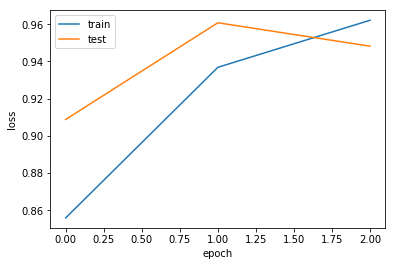

In [163]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [164]:
test_df = pd.read_csv(test_data_path,header=0,sep='\t')
test_df['text'] = test_df.review.apply(clean_text)
test_df.count()

id        25000
review    25000
text      25000
dtype: int64

In [165]:
list_token_test = tokenizer.texts_to_sequences(test_df['text'])
len(list_token_test)

25000

In [166]:
x_test = pad_sequences(list_token_test,maxlen=maxlen)
y = model.predict(x_test)

In [167]:
import numpy as np
y = y.squeeze()
y.shape
y = np.array(y>0.5,dtype=np.int)
y[0]

1

In [168]:
result_df = pd.DataFrame({'id':test_df['id'],'sentiment':y})
result_df.to_csv(os.path.join(data_path,'lstm_keras.csv'),index=False)

Object `keras.metrics` not found.
